<a href="https://colab.research.google.com/github/shaniyahali/ltp-project/blob/master/SentimentAnalysis_Using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparing Data**

In [0]:
!pip install pytorch_pretrained_bert
!pip install torch torchvision
!pip install pytorch-nlp

In [0]:
import torch

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load IMDB dataset from torchnlp

In [0]:
import random as rn
from torchnlp.datasets import imdb_dataset

rn.seed(321)

org_train_data, org_test_data = imdb_dataset(train=True, test=True)
rn.shuffle(org_train_data)
rn.shuffle(org_test_data)

In [0]:
print(len(org_test_data))

25000


In [0]:
train_data = org_train_data[:17500]
valid_data = org_train_data[17500:]
test_data = org_test_data

print(len(train_data))
print(len(valid_data))
print(len(test_data))

print(train_data[0])
print(valid_data[0])
print(test_data[0])


17500
7500
25000
{'text': 'Victor McLaglen, the title character of John Ford\'s THE INFORMER, reminded me of the circus man from Fellini\'s LA STRADA. Anthony Quinn played the brutish man, who may have even been influenced by the pug-faced, Oscar-winning performance given by McLaglen. Poverty-stricken Dublin is the true-life, atmospheric setting of the picture, which takes place in 1922. Dense fog and a long damp night are the main elements of a story about deep Irish patriotism and the fight of the Irish Republican Army. The conflict of individuality and the cause is what makes THE INFORMER tick. McLaglen\'s large, simple character just wants to go to America and we\'re reminded by signs of the price for a ticket frequently. Two different signs become the psychological centerpiece for the drunken Irishman. One is the previous, the other a WANTED sign. Should he do it and get the money to go?<br /><br />John Ford once famously said, "My name is Ford. I make Westerns." After seeing this

Using pre-trained tokens from Bert

In [0]:
from pytorch_pretrained_bert import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
valid_texts, valid_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), valid_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

print(len(train_texts), len(train_labels), len(valid_texts), len(valid_labels), len(test_texts), len(test_labels))

train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], valid_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(valid_tokens), len(test_tokens)

17500 17500 7500 7500 25000 25000


(17500, 7500, 25000)

In [0]:
from keras.preprocessing.sequence import pad_sequences
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
valid_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, valid_tokens_ids.shape, test_tokens_ids.shape

Using TensorFlow backend.


((17500, 512), (7500, 512), (25000, 512))

In [0]:
import numpy as np
train_y = np.array(train_labels) == 'pos'
valid_y = np.array(valid_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, valid_y.shape, test_y.shape, np.mean(train_y), np.mean(valid_y), np.mean(test_y)

((17500,), (7500,), (25000,), 0.4982285714285714, 0.5041333333333333, 0.5)

In [0]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 64

train_tokens_tensor = torch.tensor(train_tokens_ids)
valid_tokens_tensor = torch.tensor(valid_tokens_ids)
test_tokens_tensor = torch.tensor(test_tokens_ids)


train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()
valid_y_tensor = torch.tensor(valid_y.reshape(-1, 1)).float()
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()


train_dataset = TensorDataset(train_tokens_tensor, train_y_tensor)
valid_dataset = TensorDataset(valid_tokens_tensor, valid_y_tensor)
test_dataset = TensorDataset(test_tokens_tensor, test_y_tensor)

train_sampler = RandomSampler(train_dataset)
valid_sampler = RandomSampler(valid_dataset)
test_sampler = SequentialSampler(test_dataset)


train_iterator = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
valid_iterator = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

# Build the Model

In [0]:
import torch.nn as nn
from pytorch_pretrained_bert import BertModel   

class RNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        #self.embedding = nn.Embedding(num_embedding, embedding_dim)
        #self.embedding.weight = nn.Parameter(pretrained_embedding)
        
        model1 = BertModel.from_pretrained('bert-base-uncased')                                                                                                                           
        self.embedding = model1.embeddings.word_embeddings
        
        nb_vocab = 30522        
        embedding_dim = 768

        #self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        #self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        #lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
                        
        ##embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.linear(hidden.squeeze(0))

In [0]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

# (self, embedding_matrix, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
model = RNN(
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT
    )

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 27,119,617 trainable parameters


Set the unknown parameters to zero

# Train the Model

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
from sklearn.metrics import f1_score

def f1_score_custom(preds, labels):
  
    y_pred = torch.round(torch.sigmoid(preds))
        
    f1 = f1_score(y_pred.cpu().detach().numpy(), labels.cpu().detach().numpy())
    
    return f1

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def confusion_matrix_custom(preds, labels, normalize=False):
    y_pred = torch.round(torch.sigmoid(preds))
    
    # Compute confusion matrix
    cm = confusion_matrix(labels.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return cm


In [0]:
def plot_confusion_matrix(cm,
                          normalize=False, 
                          save=False,
                          filename='cm.png',
                          cmap=plt.cm.Blues):
  
    title = ''
    classes = ['neg', 'pos']
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' #if normalize else 'd'
    
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    if save:
      plt.savefig(filename)
    
    plt.show()

    return ax

In [0]:
import matplotlib.pyplot as plt

def loss_graph(phase, epochs, loss_hist, save=False, filename='loss_graph.png'):
  
    plt.figure(figsize=(10,5))
  
    plt.title("{0} Loss vs. Number of Training Epochs".format(phase))
    plt.xlabel("Training Epochs")
    plt.ylabel("{0} Loss".format(phase))
    
    x = range(1, epochs+1)
    y = loss_hist
    
    plt.plot(x, y, marker=5)

    plt.ylim((0, 1.))
    plt.xticks(np.arange(1, epochs+1, 1.0))
    
    plt.grid(True)
    
    if save:
      plt.savefig(filename)
    
    plt.show() 

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0    
    epoch_cm = np.zeros((2,2))
    
    model.train()
    
    for step_num, batch in enumerate(iterator):
      
      text, labels = tuple(t.to(device) for t in batch) 
      text_lengths = [len(t) for t in text]
  
      optimizer.zero_grad()

      predictions = model(text, text_lengths)

      loss = criterion(predictions, labels)

      acc = binary_accuracy(predictions, labels)
      
      f1 = f1_score_custom(predictions, labels)
      
      cm = confusion_matrix_custom(predictions, labels, normalize=False)

      loss.backward()

      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      epoch_f1 += f1
      epoch_cm = np.add(epoch_cm, cm)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator), epoch_cm

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_cm = np.zeros((2,2))
    
    model.eval()
    
    with torch.no_grad():
    
        for step_num, batch in enumerate(iterator):
        
            text, labels = tuple(t.to(device) for t in batch) 
            text_lengths = [len(t) for t in text]
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            acc = binary_accuracy(predictions, labels)
            
            f1 = f1_score_custom(predictions, labels)
            
            cm = confusion_matrix_custom(predictions, labels, normalize=False)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1
            epoch_cm = np.add(epoch_cm, cm)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator), epoch_cm

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Train and Evaluate

In [0]:
N_EPOCHS = 5

best_valid_loss = float('inf')

train_loss_hist = []
valid_loss_hist = []

train_cm = []
valid_cm = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()
    
    train_loss, train_acc, train_f1, train_cm = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1, valid_cm = evaluate(model, valid_iterator, criterion)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}  |  Train F1: {train_f1*100:.2f} %')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}  | . Val. F1: {valid_f1*100:.2f} %')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Epoch: 01 | Epoch Time: 1m 38s
	Train Loss: 0.685 | Train Acc: 53.91  |  Train F1: 43.84 %
	 Val. Loss: 0.693 |  Val. Acc: 50.24  | . Val. F1: 66.59 %
Epoch: 02 | Epoch Time: 1m 40s
	Train Loss: 0.623 | Train Acc: 65.77  |  Train F1: 60.48 %
	 Val. Loss: 0.546 |  Val. Acc: 73.43  | . Val. F1: 69.54 %
Epoch: 03 | Epoch Time: 1m 40s
	Train Loss: 0.509 | Train Acc: 76.13  |  Train F1: 73.51 %
	 Val. Loss: 0.559 |  Val. Acc: 71.31  | . Val. F1: 71.61 %
Epoch: 04 | Epoch Time: 1m 40s
	Train Loss: 0.352 | Train Acc: 85.48  |  Train F1: 84.76 %
	 Val. Loss: 0.353 |  Val. Acc: 85.43  | . Val. F1: 85.35 %
Epoch: 05 | Epoch Time: 1m 40s
	Train Loss: 0.176 | Train Acc: 93.81  |  Train F1: 93.68 %
	 Val. Loss: 0.386 |  Val. Acc: 86.04  | . Val. F1: 85.40 %


## Metrics

Graph the Loss vs Epochs

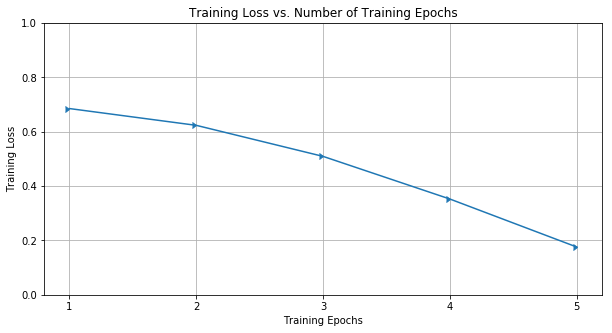

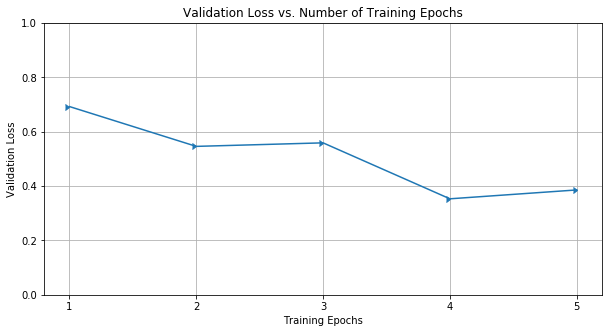

In [0]:
# Training vs Epoch
loss_graph('Training', N_EPOCHS, train_loss_hist, True, 'bert_training_loss.png')

#Validation vs Epoch
loss_graph('Validation', N_EPOCHS, valid_loss_hist, True, 'bert_validation_loss.png')


Plot the Confusion Matrix

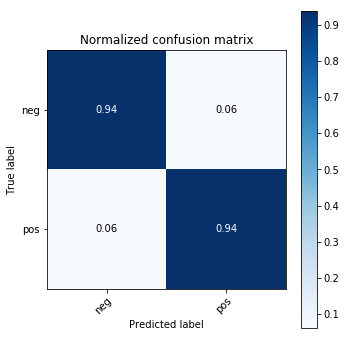

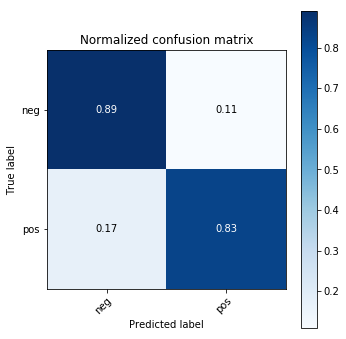

In [0]:
np.set_printoptions(precision=2)

# Plot confusion matrix for Training
plot_confusion_matrix(train_cm, normalize=True, save=True, filename='bert_training_cm.png')

# Plot confusion matrix for Validation
plot_confusion_matrix(valid_cm, normalize=True, save=True, filename='bert_validation_cm.png')


## Test

In [0]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc, test_f1, test_cm = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}  | . Test. F1: {valid_f1*100:.2f} %')

Test Loss: 0.417 | Test Acc: 82.58  | . Test. F1: 85.40 %


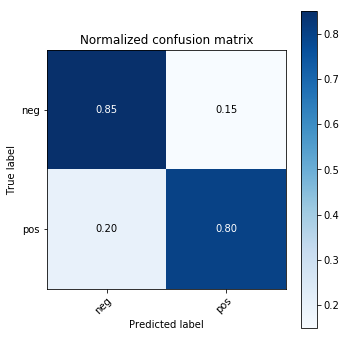

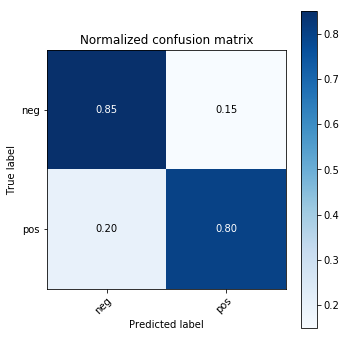

In [0]:
# Plot non-normalized confusion matrix for Training
plot_confusion_matrix(test_cm, normalize=True, save=True, filename='bert_test_cm.png')